In [2]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import nibabel as nib
import nilearn
from nilearn.plotting import plot_stat_map, plot_glass_brain
import pickle
import json
from typing import Dict, List, Tuple
from tqdm import tqdm
import warnings
from scipy import stats
from scipy.stats import sem
warnings.filterwarnings('ignore')

import networkx as nx

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches
from scipy.ndimage import gaussian_filter1d

# Set style for all plots
plt.style.use('default')
plt.rcParams.update({
    'figure.figsize': [8.0, 6.0],
    'figure.dpi': 300,
    'font.size': 10,
    'svg.fonttype': 'none',
    'figure.titlesize': 9,
    'axes.titlesize': 9,
    'axes.labelsize': 8,
    'ytick.labelsize': 6,
    'xtick.labelsize': 6,
    'axes.facecolor': 'white',
    'figure.facecolor': 'white'
})

In [9]:
 # Load environment variables
from dotenv import load_dotenv
load_dotenv()

# Setup paths
scratch_dir = os.getenv("SCRATCH_DIR")

In [10]:
# %%
# Base directory for analysis outputs
OUTPUT_DIR = Path(scratch_dir) / "output"
SAVE_DIR = Path(OUTPUT_DIR) / "final_figures"
SAVE_DIR.mkdir(parents=True, exist_ok=True)

# Groups and their data paths
GROUPS = ['affair', 'paranoia', 'combined']

# Colors for plotting
COLORS = {
    'affair': '#e41a1c',      # Red
    'affair_light': '#ff6666', # Light red
    'paranoia': '#4daf4a',    # Green
    'paranoia_light': '#90ee90', # Light green
    'combined': '#984ea3',    # Purple
    'combined_light': '#d8b2d8' # Light purple
}

In [4]:
def save_figure(fig, save_dir, filename, dpi=300, bbox_inches='tight'):
    # Remove any existing file extension from the filename
    base_filename = Path(filename).stem
    
    # Save both PNG and SVG versions
    fig.savefig(Path(save_dir) / f'{base_filename}.png', dpi=dpi, bbox_inches=bbox_inches)
    fig.savefig(Path(save_dir) / f'{base_filename}.svg', dpi=dpi, bbox_inches=bbox_inches)
    plt.close(fig)

In [11]:
SAVE_DIR_FIG1 = Path(SAVE_DIR) / "figure1"
SAVE_DIR_FIG1.mkdir(parents=True, exist_ok=True)

In [6]:
res = "native"
data_path = Path(scratch_dir) / "output" / f"atlas_masked_{res}" / "networks"
affair_file = sorted(data_path.glob(f"affair_Language*.npy"))[0]
paranoia_file = sorted(data_path.glob(f"paranoia_Language*.npy"))[0]


In [7]:
lang_affair = np.load(affair_file)
lang_paranoia = np.load(paranoia_file)

In [8]:
def plot_condition_timeseries(data, group, figsize=(4, 1), save_path=None):
    """
    Plot individual subject time series for a specific condition with mean overlay.
    
    Parameters:
    -----------
    data : numpy.ndarray
        Data with shape (n_subjects, n_conditions, n_timepoints)
    condition_idx : int
        Index of the condition to plot (default: 0)
    """
    # Get dimensions
    n_subjects, n_conditions, n_timepoints = data.shape
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Extract data for the specified condition
    condition_data = np.mean(data, axis=1)
    
    # Calculate mean across subjects
    condition_mean = np.mean(condition_data, axis=0)  # Shape: (475,)
    
    # X-axis values
    x = np.arange(n_timepoints)
    
    # Plot individual subject lines
    for i in range(n_subjects):
        ax.plot(x, condition_data[i], color=COLORS[group], alpha=0.1, linewidth=0.8)
    
    # Plot condition mean with thicker line
    ax.plot(x, condition_mean, color=COLORS[group], linewidth=1, label='Condition Mean')
    
    # Add shaded error region (standard error of the mean)
    sem = np.std(condition_data, axis=0) / np.sqrt(n_subjects)
    ax.fill_between(x, condition_mean - sem, condition_mean + sem, 
                   color=COLORS[group], alpha=0.2, label='±1 SEM')

    # Add grid for readability
    # ax.grid(True, linestyle=':', alpha=0.3)
    ax.set_xlim(0, 451)
    
    # Tight layout
    plt.tight_layout()
    plt.show()
    
    # Save if path provided
    if save_path:
       save_figure(fig, SAVE_DIR_FIG1, save_path, dpi=300, bbox_inches='tight')

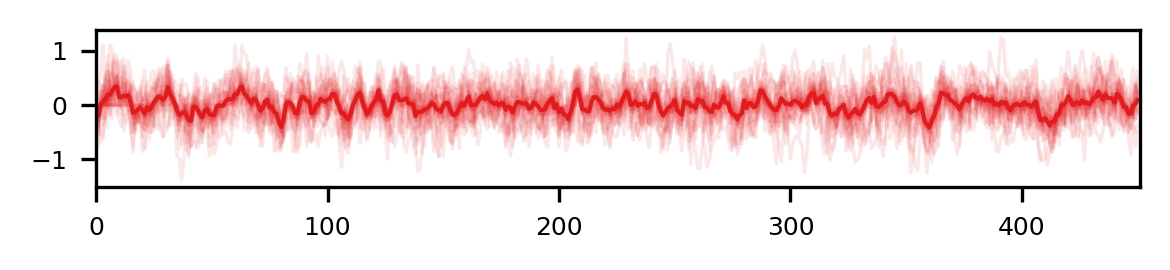

In [9]:
plot_condition_timeseries(lang_affair[:, :, 17: 468], "affair", figsize=(4, 1), save_path="affair_language")

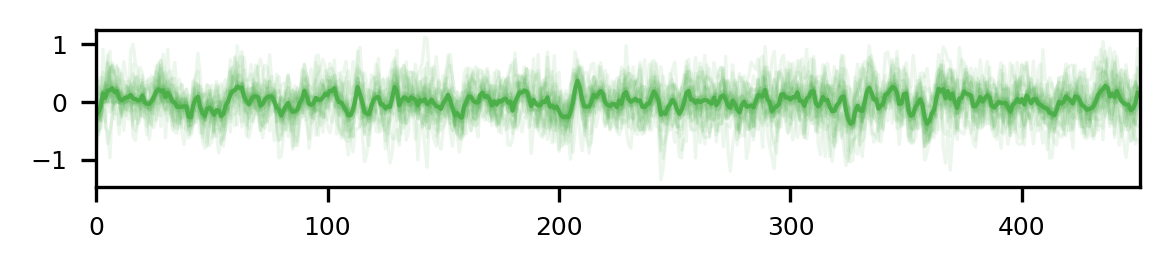

In [10]:
plot_condition_timeseries(lang_paranoia[:, :, 17: 468], "paranoia", figsize=(4, 1), save_path="paranoia_language")

In [19]:
def plot_timeseries(data, figsize=(4, 1), save_path=None):
    """
    Plot individual subject time series for a specific condition with mean overlay.
    
    Parameters:
    -----------
    data : numpy.ndarray
        Data with shape (n_subjects, n_conditions, n_timepoints)
    condition_idx : int
        Index of the condition to plot (default: 0)
    """
    # Get dimensions
    n_subjects, n_conditions, n_timepoints = data.shape
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Extract data for the specified condition
    condition_data = np.mean(data, axis=1)
    
    # X-axis values
    x = np.arange(n_timepoints)
    
    # Plot individual subject lines
    for i in range(n_subjects):
        ax.plot(x, condition_data[i], color=COLORS['combined'], alpha=0.5, linewidth=0.5)
    # Add grid for readability
    # ax.grid(True, linestyle=':', alpha=0.3)
    ax.set_xlim(0, 451)
    
    # Tight layout
    plt.tight_layout()
    plt.show()
    
    # Save if path provided
    if save_path:
       save_figure(fig, SAVE_DIR_FIG1, save_path, dpi=300, bbox_inches='tight')

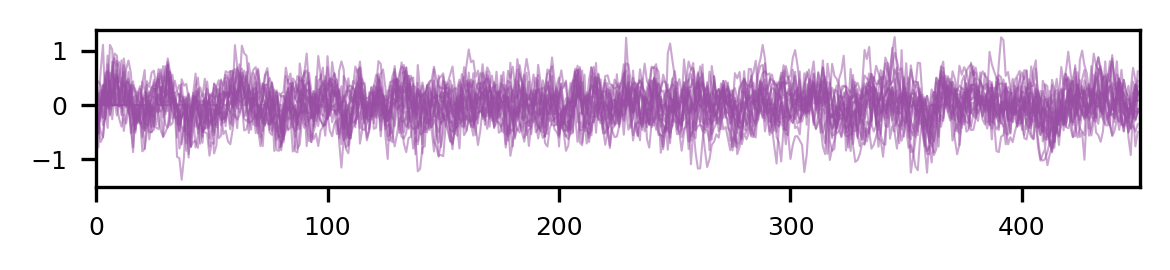

In [20]:
plot_timeseries(lang_affair[:, :, 17: 468], figsize=(4, 1), save_path="brain_timeseries")

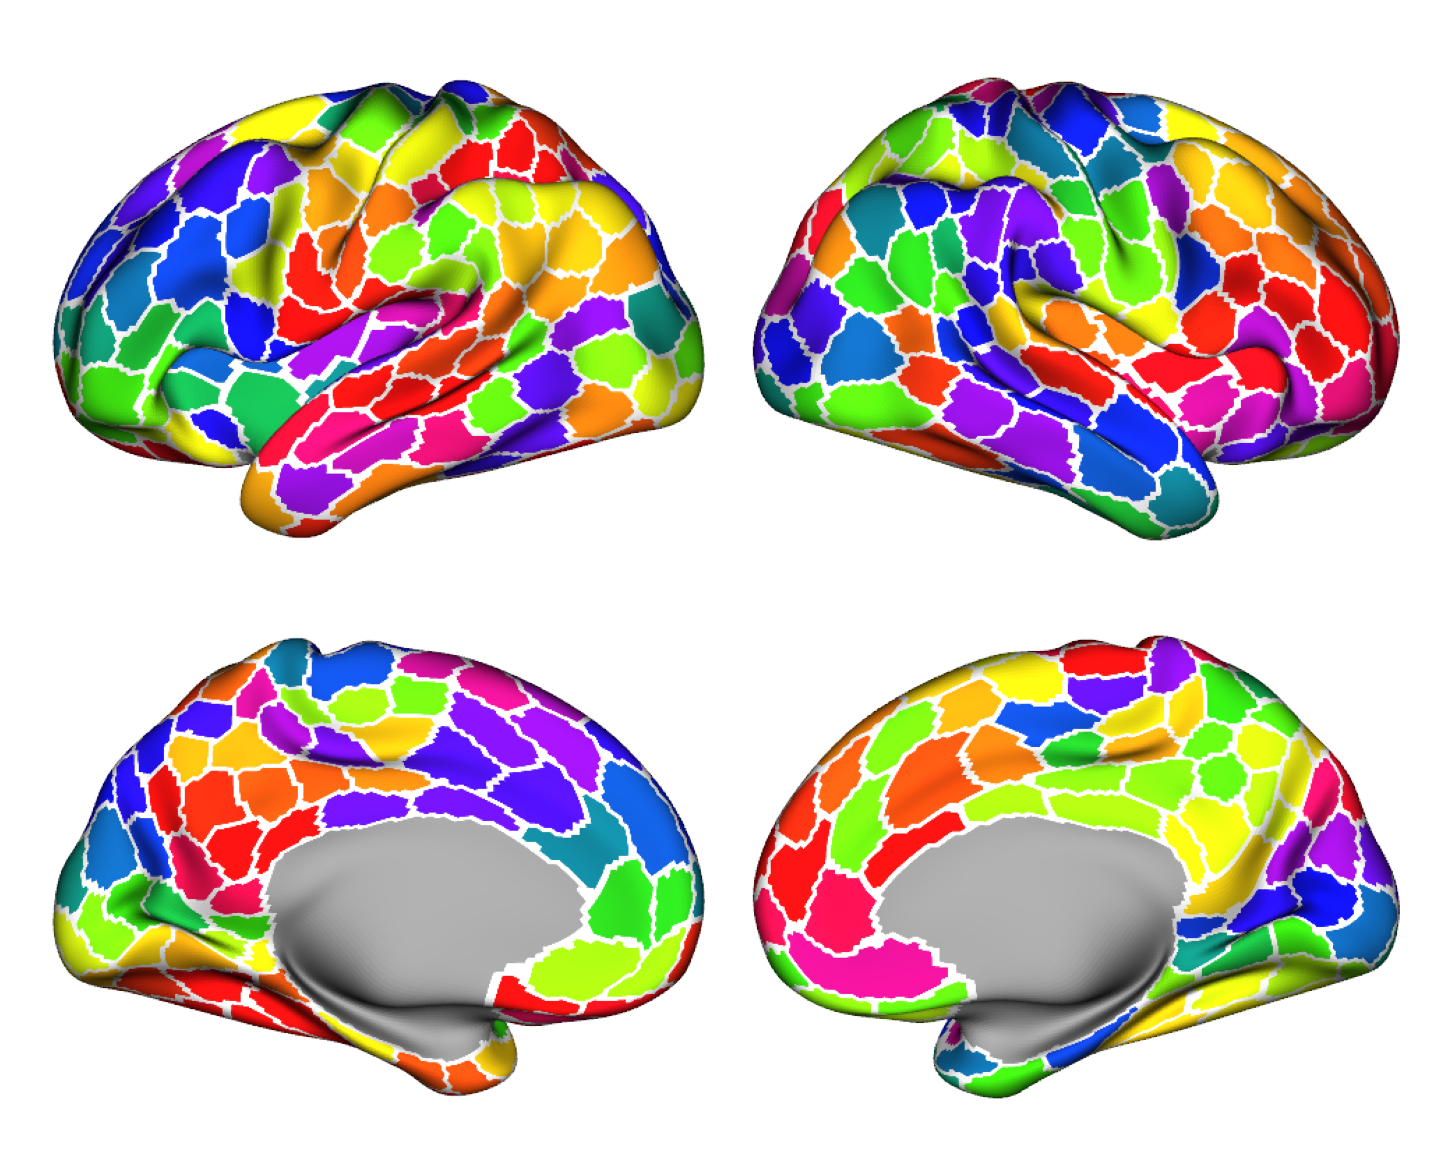

In [12]:
from neuromaps.datasets import fetch_fslr
from surfplot import Plot
from brainspace.datasets import load_parcellation

surfaces = fetch_fslr()
lh, rh = surfaces['inflated']
p = Plot(lh, rh)

# add schaefer parcellation (no color bar needed)
lh_parc, rh_parc = load_parcellation('schaefer')
p.add_layer({'left': lh_parc, 'right': rh_parc}, cmap= 'prism', cbar=False)
p.add_layer({'left': lh_parc, 'right': rh_parc}, cmap='binary',
            as_outline=True, cbar=False)
fig = p.build()
fig.show()
fig.savefig(Path(SAVE_DIR_FIG1) / "brain_parcellation.png", dpi=300, bbox_inches='tight')
fig.savefig(Path(SAVE_DIR_FIG1) / "brain_parcellation.svg", dpi=300, bbox_inches='tight')
